In [1]:
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import h
from astropy.constants import k_B

T_cmb = 2.7255

mpl.rcParams['text.usetex'] = True

In [2]:
def cmb_to_rj(freq,data):
    y          = h.value*(freq*1e9)/ (k_B.value*T_cmb)
    conversion = (y**2.0*np.exp(y))/(np.exp(y)-1)**2.0
    return data*conversion

In [3]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    # Inputs need to be in GHz.
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

In [4]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_Q_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_Q_scaled[i]   = np.nan
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_U_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_U_scaled[i]   = np.nan
        elif (pol == 'P'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_P_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_P_scaled[i]   = np.nan
        else:
            print("Unusable pol type (use 'Q', 'U', or 'P').")
            
def sky_frac(map):
    masked = 0
    for i in range(len(map)):
        if (map[i] == hp.UNSEEN):
            masked += 1
            
    print('Sky fraction: ', 1.-masked/len(map))

In [5]:
def read_params(filename):
    labels = []
    freq   = []
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('NUMBAND'):
                numbands = int(line.split('=')[1])
            if line.startswith('NUMGIBBS'):
                numgibbs = int(line.split('=')[1][:5])
                
    blabs = []
    bfreq = []
    for band in range(numbands):
        blabs.append('BAND_LABEL'+str(band+1).zfill(2))
        bfreq.append('BAND_FREQ'+str(band+1).zfill(2))        
    for band in range(numbands):
         with open(filename,'r') as infile:
            for line in infile:
                if line.startswith(blabs[band]):
                    name = str.strip(line.split('=')[1])
                    labels.append(name)
                if line.startswith(bfreq[band]):
                    fre  = str.strip(line.split('=')[1])
                    freq.append(float(fre))
    return labels, freq, numgibbs

In [6]:
dir     = str(input('Which directory are we wanting to plot from? '))
version = dir[dir.index('v'):dir.index('v')+3]
print(version)

Which directory are we wanting to plot from?  bp7.00_v26


v26


In [29]:
names, freq, num_samp = read_params('../'+dir+'/param_'+dir+'.txt')
labels = [name.replace("'","") for name in names]
labels = [w.replace("_","\_") for w in labels]
num_bands = len(freq)
print(labels)
print(freq)

['bp\\_030', 'bp\\_044', 'bp\\_070', 'wmap\\_Ka', 'wmap\\_Q']
[28.4, 44.1, 70.3, 33.0, 40.6]


In [30]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0,verbose=False)
npix         = len(ame_map)

In [31]:
# synch_Q_030  = np.empty((npix,num_samp))
# synch_U_030  = np.empty((npix,num_samp))

# for j in range(num_samp):
#     iter = str(j+1).zfill(5)
#     synch_Q_030.T[:][j] = hp.read_map('../'+dir+'/'+'bp_030_synch_amplitude_Q_'+iter+'.fits',verbose=False)
#     synch_U_030.T[:][j] = hp.read_map('../'+dir+'/'+'bp_030_synch_amplitude_U_'+iter+'.fits',verbose=False)


In [32]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
synch_Q_030  = hp.read_map('../'+dir+'/bp_030_synch_amplitude_Q_00005.fits',verbose=False)
synch_U_030  = hp.read_map('../'+dir+'/bp_030_synch_amplitude_U_00005.fits',verbose=False)
dust_Q_amps  = np.loadtxt('../'+dir+'/dust_Q_amplitudes.dat')
dust_Q_unc   = np.loadtxt('../'+dir+'/dust_Q_uncertainties.dat')
dust_U_amps  = np.loadtxt('../'+dir+'/dust_U_amplitudes.dat')
dust_U_unc   = np.loadtxt('../'+dir+'/dust_U_uncertainties.dat')

In [33]:
# Planck 2015 2 component AME details
ame_comp1 = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2 = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz

In [34]:
# Some plotting array of frequencies
x = np.linspace(5,1000,1000)

In [35]:
dust_353     = cmb_to_rj(353,dust_353)
dust_353_rms = cmb_to_rj(353,dust_353_rms)

In [36]:
dust_353_P   = np.empty(len(synch_Q_030))
dust_P_rms   = np.empty(len(synch_Q_030))
synch_P_030  = np.empty(np.shape(synch_Q_030))
dust_P_amps  = np.empty(np.shape(dust_Q_amps))
dust_P_unc   = np.empty(len(dust_Q_unc))

dust_Q_means = np.empty(np.shape(dust_Q_amps)[1])
dust_U_means = np.empty(np.shape(dust_U_amps)[1])
dust_P_means = np.empty(np.shape(dust_Q_means))
dust_Q_std   = np.empty(np.shape(dust_Q_amps)[1])
dust_U_std   = np.empty(np.shape(dust_U_amps)[1])
dust_P_std   = np.empty(np.shape(dust_Q_means))

dust_Q_amps *= 12.9055
dust_U_amps *= 12.9055

for i in range(npix):
    dust_353_P[i]  = np.sqrt(dust_353[1][i]**2 + dust_353[2][i]**2)
    dust_P_rms[i]  = np.sqrt(dust_353_rms[1][i]**2 + dust_353_rms[2][i]**2)
    if False:
        for j in range(num_samp):
            synch_P_030.T[j][i] = np.sqrt(synch_Q_030.T[j][i]**2 + synch_U_030.T[j][i]**2)
    else:
        synch_P_030[i] = np.sqrt(synch_Q_030[i]**2 + synch_U_030[i]**2)

for i in range(num_samp):
    for j in range(num_bands):
        dust_P_amps[i][j] = np.sqrt(dust_Q_amps[i,j]**2 + dust_U_amps[i,j]**2)
    
for i in range(len(dust_Q_unc)):
    dust_P_unc[i] = np.sqrt(dust_Q_unc[i]**2 + dust_U_unc[i]**2)

for i in range(len(dust_Q_means)):
    dust_Q_means[i] = np.mean(dust_Q_amps.T[:][i])
    dust_U_means[i] = np.mean(dust_U_amps.T[:][i])
    dust_P_means[i] = np.sqrt(dust_Q_means[i]**2 + dust_U_means[i]**2)
    dust_Q_std[i]   = np.std(dust_Q_amps.T[:][i])
    dust_U_std[i]   = np.std(dust_U_amps.T[:][i])
    dust_P_std[i]   = np.std(dust_P_amps.T[:][i])
   
    
print(dust_Q_means,dust_Q_std,dust_Q_unc)
print(dust_U_means,dust_U_std,dust_U_unc)
print(dust_P_means,dust_P_std,dust_P_unc)

[0.         0.0307638  0.         0.07767276 0.04693179] [0.         0.00151295 0.         0.00162406 0.00123735] [0.41166377 0.40930242 0.32423733]
[0.         0.05621049 0.         0.03398912 0.05616768] [0.         0.00281415 0.         0.00388178 0.0026975 ] [0.74393277 0.91538827 0.73993807]
[0.         0.06407831 0.         0.08478395 0.07319427] [0.         0.00259799 0.         0.00230321 0.00225641] [0.85023704 1.00272836 0.80786026]


In [37]:
planck_XI_freq = [44.1,70.3]
planck_XI_mean = [6.0e-3,9.46e-3]
planck_XI_err  = [1.1e-3,0.75e-3]

for i in range(2):
#     planck_XI_mean[i] = cmb_to_rj(353.,planck_XI_mean[i])
#     planck_XI_err[i]  = cmb_to_rj(353.,planck_XI_err[i])
    planck_XI_mean[i] = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_mean[i])
    planck_XI_err[i]  = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_err[i])
   
print(planck_XI_mean)
print(planck_XI_err)

[0.0736564217277, 0.10762147257140103]
[0.013503677316745, 0.008532357762003251]


In [38]:
# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.
mono_dip       = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False,fitval=True)
# print(mono_dip[1])
dust_353[0][:] = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False) + mono_dip[1]

synch_Q_scaled = synch_Q_030/dust_353[1]
synch_U_scaled = synch_U_030/dust_353[2]
synch_P_scaled = synch_P_030/dust_353_P

In [39]:
# synch_Q_scaled  = np.empty((npix,num_samp))
# synch_U_scaled  = np.empty((npix,num_samp))
# synch_P_scaled  = np.empty((npix,num_samp))

# for j in range(num_samp):
#     for i in range(npix):
#         synch_Q_scaled.T[j][i]  = synch_Q_030.T[j][i]/dust_353[1][i]
#         synch_U_scaled.T[j][i]  = synch_U_030.T[j][i]/dust_353[2][i]
#         synch_P_scaled.T[j][i]  = synch_P_030.T[j][i]/dust_353_P[i]
#         if np.abs(synch_Q_scaled.T[j][i]) > 3.5e5:
#             synch_Q_scaled.T[j][i] = np.nan
#         if np.abs(synch_U_scaled.T[j][i]) > 3.5e5:
#             synch_U_scaled.T[j][i] = np.nan
#         if np.abs(synch_P_scaled.T[j][i]) > 3.5e5:
#             synch_P_scaled.T[j][i] = np.nan

#     print(j)
#     print('Synch Q scaled')
#     print(np.nanmax(synch_Q_scaled.T[j]))
#     print(np.nanstd(synch_Q_scaled.T[j]))
#     print(np.nanmin(synch_Q_scaled.T[j]))
#     print('')
#     print('Synch Q')
#     print(np.max(synch_Q_030.T[j]))
#     print(np.std(synch_Q_030.T[j]))
#     print(np.min(synch_Q_030.T[j]))
#     print('----------')
#     print('')

# print(np.where(np.abs(synch_Q_scaled) > 10000))
    
# print(synch_Q_030.T[0][2312])
# print(dust_353[1][2312])
    
# print('')
# print(np.max(synch_Q_030))
# print(np.min(synch_Q_030))
# print('')
# print(np.max(dust_353[1][:]))
# print(np.min(dust_353[1][:]))
# print('')
# # print(np.max(synch_Q_scaled))
# # print(np.min(synch_Q_scaled))
# hp.mollview(synch_Q_scaled.T[1][:],min=-10,max=10)
# # hp.mollview(dust_353[1][:])

In [40]:
# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course

I_ame_over_I_353    = ame_map/dust_353[0][:]

In [41]:
# Make signal to noise maps 
s_n_Q        = dust_353[1][:]/dust_353_rms[1][:]
s_n_U        = dust_353[2][:]/dust_353_rms[2][:]
s_n_P        = dust_353_P/dust_P_rms
mask_Q       = np.empty(len(s_n_Q))
mask_U       = np.empty(len(s_n_U))
mask_P       = np.empty(len(s_n_P))

# Write something here about choosing a pixel, or s/n ratio for a sky fraction

sn_lim = float(input('Signal to noise limit: '))

npix = len(synch_Q_030)
Q_masked = 0
U_masked = 0
P_masked = 0

Signal to noise limit:  10


In [42]:
for i in range(len(s_n_Q)):
    if (np.abs(s_n_Q[i]) > sn_lim):
        mask_Q[i] = 1.0
    else:
        Q_masked += 1
        mask_Q[i] = hp.UNSEEN
        s_n_Q[i]  = hp.UNSEEN

    if (np.abs(s_n_U[i]) > sn_lim):
        mask_U[i] = 1.0
    else:
        U_masked += 1
        mask_U[i] = hp.UNSEEN
        s_n_U[i]  = hp.UNSEEN
        
    if (np.abs(s_n_P[i]) > sn_lim):
        mask_P[i] = 1.0
    else:
        P_masked += 1
        mask_P[i] = hp.UNSEEN
        s_n_P[i]  = hp.UNSEEN

In [43]:
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

In [44]:
mask_maps(mask_Q,'Q')
sky_frac(mask_Q)
mask_maps(mask_U,'U')
sky_frac(mask_U)
mask_maps(mask_P,'P')
sky_frac(mask_P)

# hp.mollview(I_ame_over_I_353,min=-1,max=1)
# plt.show()

# hp.write_map('mask_dust_P_s_n_n0064_60arcmin.fits',mask_P)
# hp.mollview(mask_P)
# plt.show()

ame_over_353_median = np.nanmedian(I_ame_over_I_353)
ame_over_353_mean   = np.nanmean(I_ame_over_I_353)
print(ame_over_353_median)
print(ame_over_353_mean)
spdust_tot *= ame_over_353_mean


Sky fraction:  0.35308837890625
Sky fraction:  0.24070231119791663
Sky fraction:  0.35109456380208337
0.5689430158981534
0.5960158894196828


In [45]:
# ame_col = ['yellow','gold','orange','darkorange','orangered']
ame_col = ['goldenrod','orange','darkorange','chocolate','saddlebrown']
amp_col = ['royalblue','cadetblue','steelblue','darkturquoise','cyan']

In [46]:
# # synch_Q_scaled = np.swapaxes(synch_Q_scaled,0,1)
# s_Q_mean_map = np.empty((npix))
# s_Q_std_map  = np.empty((npix))
# s_U_mean_map = np.empty((npix))
# s_U_std_map  = np.empty((npix))
# s_P_mean_map = np.empty((npix))
# s_P_std_map  = np.empty((npix))
# for j in range(npix):
# #     print(np.shape(synch_Q_scaled[j]))
#     s_Q_mean_map[j] = np.nanmean(synch_Q_scaled[j])
#     s_Q_std_map[j]  = np.nanstd(synch_Q_scaled[j])
    
#     s_U_mean_map[j] = np.nanmean(synch_U_scaled[j])
#     s_U_std_map[j]  = np.nanstd(synch_U_scaled[j])

#     s_P_mean_map[j] = np.nanmean(synch_P_scaled[j])
#     s_P_std_map[j]  = np.nanstd(synch_P_scaled[j])
    
# s_Q_sky_mean = np.mean(s_Q_mean_map)
# s_Q_std_mean = np.mean(s_Q_std_map)
# s_Q_std_max  = np.max(s_Q_std_map)
# # s_U_sky_mean = np.mean(s_U_mean_map)
# # s_P_sky_mean = np.mean(s_P_mean_map)

# print('Q',s_Q_sky_mean,s_Q_std_mean,s_Q_std_max)

# # hp.mollview(s_Q_mean_map,min=-10,max=10,fig=2)
# # hp.mollview(s_Q_std_map,min=0,max=5,fig=3)
# # hp.mollview(synch_Q_030.T[0],min=-150,max=150)
# # plt.show()

In [47]:
s_Q_mean = np.nanmean(synch_Q_scaled)
s_Q_std  = np.nanstd(synch_Q_scaled)
s_Q_low  = s_Q_mean - s_Q_std
s_Q_high = s_Q_mean + s_Q_std
print("Q",s_Q_low,s_Q_mean,s_Q_high)

s_U_mean = np.nanmean(synch_U_scaled)
s_U_std  = np.nanstd(synch_U_scaled)
s_U_low  = s_U_mean - s_U_std
s_U_high = s_U_mean + s_U_std
print("U",s_U_low,s_U_mean,s_U_high)

s_P_mean = np.nanmean(synch_P_scaled)
s_P_std  = np.nanstd(synch_P_scaled)
s_P_low  = s_P_mean - s_P_std
s_P_high = s_P_mean + s_P_std
print("P",s_P_low,s_P_mean,s_P_high)

Q -0.5951733358207881 0.7687470989268365 2.132667533674461
U -1.2883773788931572 0.5258064116206809 2.339990202134519
P 0.10366949821756566 1.1905914714593957 2.277513444701226


In [56]:
def plot_Q_Q353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_Q_mean,30.0,x,-3.1),color='green',label='Synch')
#     ax.plot(x,power_law(s_Q_high,30.0,x,-3.1),color='green',linestyle='--')
#     ax.fill_between(x,power_law(s_Q_low,30.0,x,-3.1),power_law(s_Q_high,30.0,x,-3.1),color='Green',alpha=0.2)

    # MBB Plotting
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.7),color='red',label='Thermal Dust')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.6$',linestyle='--')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color='red',label='Planck 2018 Dust Pol MBB') # Planck 2018 Dust Pol MBB
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.5),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.3$',linestyle='-.')

    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    
    # AME Pol
#     ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
#     ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
#     ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
#     ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
#     ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')

    k = 0
    for j in range(len(freq)):
        if dust_Q_amps[0][j] == 0.0:
            continue
        else:
            if sample == 'mean':
                ax.scatter(freq[j],dust_Q_means[j],label=labels[j],color=amp_col[k],zorder=10)#,s=10)
#                 ax.errorbar(freq[j],dust_Q_means[j],dust_Q_std[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_Q_means[j],dust_Q_unc[k],color=amp_col[k],zorder=10)
            else:
                ax.scatter(freq[j],dust_Q_amps[sample,j],label=labels[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_Q_amps[sample,j],dust_Q_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='k',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_Q_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-3,6e0])
        ax.set_xlim([5,353.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_title('AME Pol '+version+' - Q Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$Q/Q_{353}\, [\mu \mathrm{K_{RJ}}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency [GHz]}$',size=20)
    ax.legend(loc=1,)# prop={'size': 15})
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_Q353_sample_'+str(sample)+'_'+version+'.png',dpi=300,bbox_inches='tight')
#     plt.show()

def plot_U_U353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_U_mean,30.0,x,-3.1),color='green',label='Synch')
#     ax.fill_between(x,power_law(s_U_low,30.0,x,-3.1),power_law(s_U_high,30.0,x,-3.1),color='Green',alpha=0.2)

    # MBB Plotting
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.7),color='red',label='Thermal Dust')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.6$',linestyle='--')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color='red',label='Planck 2018 Dust Pol MBB') # Planck 2018 Dust Pol MBB
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.5),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.3$',linestyle='-.')

    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    
    # AME Pol
#     ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
#     ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
#     ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
#     ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
#     ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    
    k = 0
    for j in range(len(freq)):
        if dust_U_amps[0][j] == 0.0:
            continue
        else:
            if sample == 'mean':
                ax.scatter(freq[j],dust_U_means[j],label=labels[j],color=amp_col[k],zorder=10)#,s=10)
#                 ax.errorbar(freq[j],dust_U_means[j],dust_U_std[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_U_means[j],dust_U_unc[k],color=amp_col[k],zorder=10)
            else:
                ax.scatter(freq[j],dust_U_amps[sample,j],label=labels[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_U_amps[sample,j],dust_U_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,fmt='.',color='k',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_Q_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-3,6e0])
        ax.set_xlim([5,353.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_title('AME Pol '+version+' - U Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$U/U_{353}\, [\mu \mathrm{K_{RJ}}]$',size=20)
    ax.set_xlabel('Frequency [GHz]',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_U353_sample_'+str(sample)+'_'+version+'.png',dpi=300,bbox_inches='tight')\
#     plt.show()
    
def plot_P_P353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_P_mean,30.0,x,-3.1),color='green',label='Synch')
    ax.fill_between(x,power_law(s_P_low,30.0,x,-3.1),power_law(s_P_high,30.0,x,-3.1),color='Green',alpha=0.2)
    
    # MBB Plotting
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.7),color='red',label='Thermal Dust')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.6$',linestyle='--')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color='red',label='Planck 2018 Dust Pol MBB') # Planck 2018 Dust Pol MBB
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.5),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.3$',linestyle='-.')

    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    
    # AME Pol
#     ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
#     ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
#     ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
#     ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
#     ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    
    k = 0
    for j in range(len(freq)):
        if dust_U_amps[0][j] == 0.0:
            continue
        else:
            if sample == 'mean':
                ax.scatter(freq[j],dust_P_means[j],label=labels[j],color=amp_col[k],zorder=10)#,s=10)
                ax.errorbar(freq[j],dust_P_means[j],dust_P_std[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_P_means[j],dust_P_unc[k],color=amp_col[k],zorder=10)
            else:
                ax.scatter(freq[j],dust_P_amps[sample,j],label=labels[j],color=amp_col[k],zorder=10)
                ax.errorbar(freq[j],dust_P_amps[sample,j],dust_P_unc[k],color=amp_col[k],zorder=10)
            k += 1
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,fmt='.',color='k',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_Q_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-3,6e0])
        ax.set_xlim([5,353.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_title('AME Pol '+version+' - P Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$P/P_{353}\, [\mu \mathrm{K_{RJ}}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency [GHz]}$',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_P353_sample_'+str(sample)+'_'+version+'.png',dpi=300,bbox_inches='tight')
#     plt.show()    

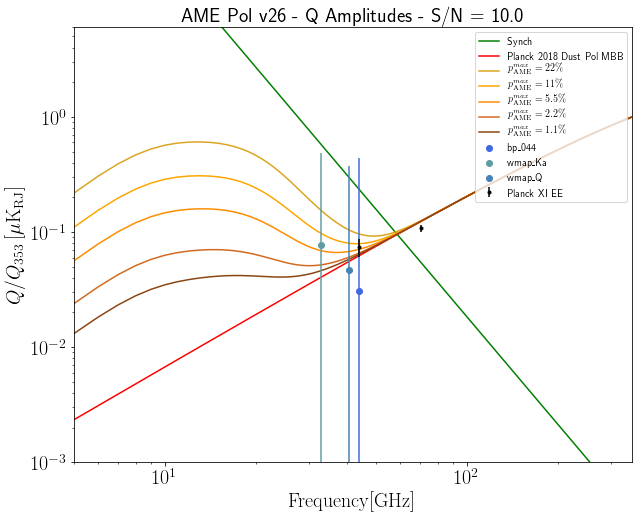

In [57]:
plot_Q_Q353('mean')

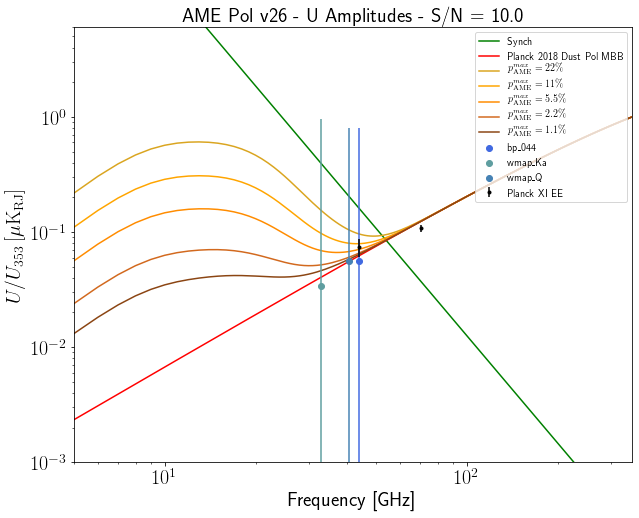

In [58]:
plot_U_U353('mean')

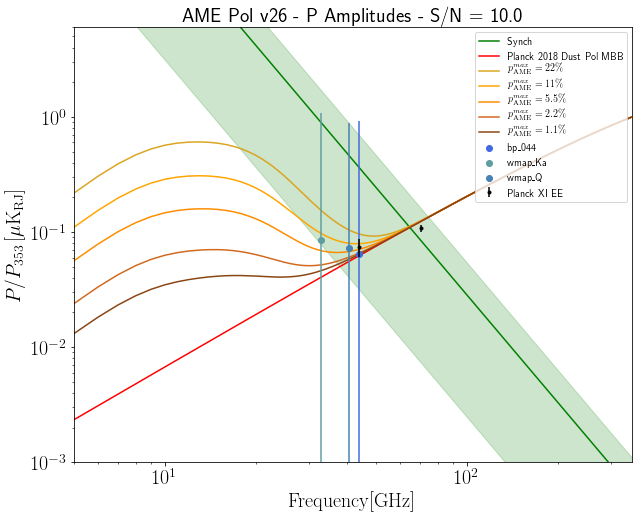

In [59]:
plot_P_P353('mean')